In [27]:
import numpy as np
import argparse
#from custom_function import *
from glob import iglob
from collections import defaultdict
import scipy.ndimage
import scipy.io as sio
import sys
import os
import csv
from scipy.ndimage.interpolation import shift
import scipy.io
from scipy.io import savemat

def my_read_bin(cur_inp_file, data_type, input_shape):
  A = np.fromfile(cur_inp_file, dtype = data_type)
  A[np.isnan(A)] = 0
  A = np.reshape(A, input_shape)
  A = np.transpose(A, [2, 1, 0])
  return A

def my_write_bin(cur_out_file, data_type, data):
  #data = np.transpose(data, [2, 0, 1])
  data.astype(data_type).tofile(cur_out_file)
  return

def center_to_def_loc(SA_rec, cur_loc, offset):
  SA_rec_sliced = SA_rec[:,:,cur_loc[2]+offset]
  sh_x = SA_rec_sliced.shape[1]//2 - cur_loc[0]
  sh_y = SA_rec_sliced.shape[0]//2 - cur_loc[1]
  SA_rec_sh = shift(SA_rec_sliced, [sh_y, sh_x], prefilter=False)
  return SA_rec_sh


def read_patient_file(file_path):
    """
    Reads the patient selection file and returns the lists of diseased and healthy patients.

    Parameters:
    file_path (str): The path to the patient selection text file.

    Returns:
    Tuple[List[str], List[str]]: A tuple containing two lists: one for diseased patients and one for healthy patients.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    diseased_patients = []
    healthy_patients = []
    is_diseased = False
    is_healthy = False

    for line in lines:
        line = line.strip()
        if line == "Selected diseased patients:":
            is_diseased = True
            is_healthy = False
        elif line == "Selected healthy patients:":
            is_diseased = False
            is_healthy = True
        elif is_diseased:
            if line:
                diseased_patients.append(line)
        elif is_healthy:
            if line:
                healthy_patients.append(line)

    return diseased_patients, healthy_patients


pat_id_arr_fname = f'/data01/user-storage/y.zezhang/2024_subsample_project/document/zitong_patient_list/pat_id_diseased_v3.txt'
diseased_patients = np.loadtxt(pat_id_arr_fname, dtype = 'str', comments="#", delimiter=",", unpack=False)

pat_id_arr_fname = f'/data01/user-storage/y.zezhang/2024_subsample_project/document/zitong_patient_list/pat_id_healthy_v3.txt'
healthy_patients = np.loadtxt(pat_id_arr_fname, dtype = 'str', comments="#", delimiter=",", unpack=False)

isIO=0

dl_version='2s'
batch_size=32
subsample_level=15
bt_size=32
lambda_val_ind_mdiff=0

lambda_val_ind_chdiff=7
#lambda_val_ind_chdiff=0


Ud=32
isIO=0

location_setting=['i','a']  #['a','i']
extent_setting = [30,60]  #[30,45,60] 
severity_setting= [100,175,250] # [100,175,250]


base_folder = f'/data01/user-storage/y.zezhang/2024_subsample_project/mod_Neural_network_training/learning/subsample_3d_v{dl_version}/pred'##########################
save_base_folder = f'/data01/user-storage/y.zezhang/2024_subsample_project/mod_Neural_network_training/learning/subsample_3d_v{dl_version}'#
save_folder = f'{save_base_folder}/SNR/NN_lmbd_mdiff{lambda_val_ind_chdiff}/d{subsample_level}/'###########
def_folder='/data01/user-storage/y.zezhang/2024_subsample_project/mod_Neural_network_training/centroid_mask/testing'

SA_folder='/data01/user-storage/y.zezhang/2024_subsample_project/mod_SA_images'

#if not os.path.isdir(save_folder):
#  os.mkdir(save_folder)
os.makedirs(save_folder, exist_ok=True)

inp_shape = (48, 48, 48)
inp_shape_orig = (48, 48, 48)

#observer_study_list = os.listdir('/data01/user-storage/y.zezhang/2024_subsample_project/mod_SA_images')


print('loading pre-written channels file...')
if Ud == 32:
    U_flag = ''
elif Ud == 64:
    U_flag = f'_{Ud}'

U = np.load(f'/data01/user-storage/y.zezhang/2024_subsample_project/mod_Neural_network_training/U{U_flag}.npy')
print('U shape: ',U.shape)
U = np.transpose(U, [1,0])

print(f'loading images... || D: {subsample_level}')
ff = {'diseased':defaultdict(list), 'healthy':defaultdict(list)}
pat_ind_arr = {'diseased':diseased_patients , 'healthy':healthy_patients}
#pat_ind_arr_src = {'diseased':def_pat_list_src, 'healthy':hl_pat_list_src}

#def_name_arr = []
#for diag in ['diseased', 'healthy']:
    #for idx_list in range(len(pat_ind_arr[diag])):
      #pat_ind = pat_ind_arr[diag][idx_list]
      #src_name = pat_ind_arr_src[diag][idx_list]
      #print(pat_ind)
      
      
for location in location_setting:
    for extent in extent_setting:
        for severity in severity_setting:
            for diag in ['diseased', 'healthy']:
                    subensemble_idx = 0
                    if diag == 'diseased':
                        for di_item in diseased_patients:
                            patient=di_item
                            
                            def_name = f'd{location}21{extent}s{severity}'
                            def_centroid_type=def_name.split('s')[0]
                            
                            nn_folder=f'd{subsample_level}_lmbdchdiff{lambda_val_ind_chdiff}_nn'
                            cur_path=os.path.join(SA_folder,nn_folder,diag,patient,'CTAC',def_name)
                            
                            SA_fname='extended_reoriented_windowed.img'
                        
                            SA_name=os.path.join(cur_path,SA_fname)
                            
                            def_loc_path=os.path.join(def_folder,patient)
                            def_loc_fname=def_loc_path +'/'+ 'def_centroid_' + def_centroid_type + '_mod.bin'
                            
                            SA_rec_base = my_read_bin(SA_name, 'float32', inp_shape_orig)    
                            cur_loc = np.fromfile(def_loc_fname, dtype = 'float32').astype(int) - 1 #0 -based / but nn2D has 1 shift
                            
                            for offset in [7,8,9]:
                                SA_rec = center_to_def_loc(SA_rec_base, cur_loc, offset)
                                SA_rec = SA_rec[8:40,8:40]
                                if Ud != 32:
                                    SA_rec = scipy.ndimage.zoom(SA_rec, Ud/32, order=0) # upsampling to 512X512
                                SA_rec = (SA_rec-np.min(SA_rec))/(np.max(SA_rec)-np.min(SA_rec))*255
                                #SA_rec = SA_rec - np.mean(SA_rec) # remove zero frequency component
                                ff[diag][subensemble_idx].append(SA_rec.flatten())
                            
            
                
                    elif diag == 'healthy':
                        for hl_item in healthy_patients:
                            
                            patient=hl_item
                            #cur_path=os.path.join(SA_folder,'hl')
                            
                            nn_folder=f'd{subsample_level}_lmbdchdiff{lambda_val_ind_chdiff}_nn'
                            cur_path=os.path.join(SA_folder,nn_folder,diag,patient,'CTAC','hl')
                        
                            SA_fname='extended_reoriented_windowed.img'

                            #SA_fname='recon_pat'+ patient +'_'+'hl'+'_d'+str(subsample_level)+'_it8_b'+str(bt_size)+'_lmbdchdiff'+str(lambda_val_ind_chdiff)+'_lmbdmdiff'+str(lambda_val_ind_mdiff)+'.img'              
                            SA_name=os.path.join(cur_path,SA_fname)
                            
                            def_name = f'd{location}21{extent}s{severity}'
                            def_loc_path=os.path.join(def_folder,patient)
                            def_loc_fname=def_loc_path +'/'+ 'def_centroid_' + def_centroid_type + '_mod.bin'
                            
                            SA_rec_base = my_read_bin(SA_name, 'float32', inp_shape_orig)    
                            cur_loc = np.fromfile(def_loc_fname, dtype = 'float32').astype(int) - 1 #0 -based / but nn2D has 1 shift 
                            
                            for offset in [7,8,9]:
                                SA_rec = center_to_def_loc(SA_rec_base, cur_loc, offset)
                                SA_rec = SA_rec[8:40,8:40]
                                if Ud != 32:
                                    SA_rec = scipy.ndimage.zoom(SA_rec, Ud/32, order=0) # upsampling to 512X512
                                SA_rec = (SA_rec-np.min(SA_rec))/(np.max(SA_rec)-np.min(SA_rec))*255
                                #SA_rec = SA_rec - np.mean(SA_rec) # remove zero frequency component
                                ff[diag][subensemble_idx].append(SA_rec.flatten())
                        


/tmp/ipykernel_34761/2610531754.py:11: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


loading pre-written channels file...
U shape:  (1024, 4)
loading images... || D: 15


In [23]:
np.shape(ff['diseased'][0])

(4716, 1024)

In [19]:
np.size(ff['healthy'][0])

647110656

In [20]:
ff['healthy'][0]

[array([ 36.78581 ,  44.278107,  60.83449 , ..., 124.1842  , 142.72441 ,
        150.87868 ], dtype=float32),
 array([ 31.770649,  39.72268 ,  57.25081 , ..., 126.539   , 146.47244 ,
        157.17647 ], dtype=float32),
 array([ 30.43887 ,  37.309433,  54.366768, ..., 125.1765  , 147.98865 ,
        161.58171 ], dtype=float32),
 array([105.13801 , 102.92865 , 100.36196 , ..., 163.98009 , 126.425095,
         84.965866], dtype=float32),
 array([101.41688 , 100.569725, 101.29646 , ..., 152.04291 , 119.018906,
         80.84059 ], dtype=float32),
 array([ 96.85667,  98.64235, 102.74029, ..., 140.20293, 109.46142,
         75.59571], dtype=float32),
 array([ 49.88405 ,  50.317184,  61.74103 , ...,  94.312004,  97.666145,
        101.28363 ], dtype=float32),
 array([48.389706, 43.406803, 49.34609 , ..., 83.70113 , 84.55235 ,
        87.28609 ], dtype=float32),
 array([52.835926, 43.392197, 43.843437, ..., 73.32739 , 73.019554,
        76.88941 ], dtype=float32),
 array([62.493816, 61.446995

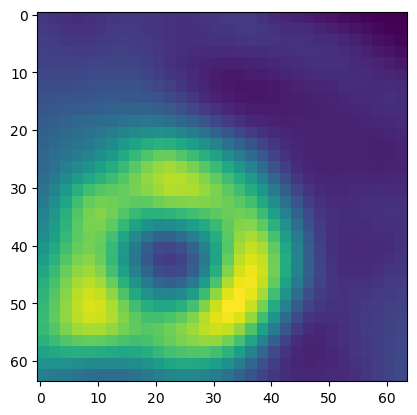

In [26]:
import matplotlib.pyplot as plt
plt.imshow(SA_rec)

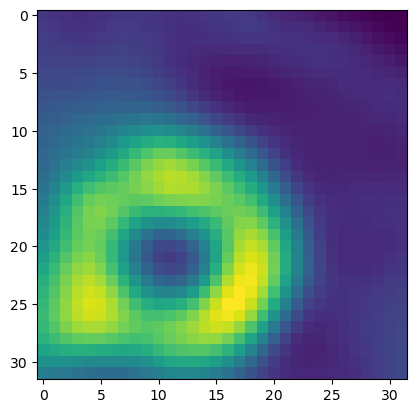

In [28]:
import matplotlib.pyplot as plt
plt.imshow(SA_rec)